In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#load data
train_df = pd.read_excel('train.xlsx')
test_df = pd.read_excel('test.xlsx')

In [3]:
train_cycles = list(set(np.array(train_df['Cycle_Index'])))
test_cycles = list(set(np.array(test_df['Cycle_Index'])))

In [4]:
train_voltage = []
train_current = []
train_temp = []
train_charge_cap = []
train_discharge_cap = []
for i in train_cycles:
    dat = train_df[train_df['Cycle_Index'] == i]
    train_voltage.append(np.array(dat['Voltage(V)']))
    train_current.append(np.array(dat['Current(A)']))
    train_temp.append(np.array(dat['Aux_Temperature(℃)_1']))
    train_charge_cap.append(np.array(dat['Charge_Capacity(Ah)']))
    train_discharge_cap.append(np.array(dat['Discharge_Capacity(Ah)']))

In [5]:
#maximum length of time series is 362, so prepend zeros to make same length
train_data =[]
for i in range(0, len(train_cycles)):
    d1 = list(np.zeros(362-len(train_voltage[i]))) + list(train_voltage[i])
    d2 = list(np.zeros(362-len(train_current[i]))) + list(train_current[i])
    d3 = list(np.zeros(362-len(train_charge_cap[i]))) + list(train_charge_cap[i])
    d4 = list(np.zeros(362-len(train_temp[i]))) + list(train_temp[i])
    train_data.append([d1, d2, d3, d4])
train_data = np.array(train_data)

train_labels = [train_discharge_cap[i][-1] for i in range(0, len(train_discharge_cap))]

In [6]:
test_voltage = []
test_current = []
test_temp = []
test_charge_cap = []
test_discharge_cap = []
for i in test_cycles:
    dat = test_df[test_df['Cycle_Index'] == i]
    test_voltage.append(np.array(dat['Voltage(V)']))
    test_current.append(np.array(dat['Current(A)']))
    test_temp.append(np.array(dat['Aux_Temperature(℃)_1']))
    test_charge_cap.append(np.array(dat['Charge_Capacity(Ah)']))
    test_discharge_cap.append(np.array(dat['Discharge_Capacity(Ah)']))

test_data =[]
for i in range(0, len(test_cycles)):
    d1 = list(np.zeros(362-len(test_voltage[i]))) + list(test_voltage[i])
    d2 = list(np.zeros(362-len(test_current[i]))) + list(test_current[i])
    d3 = list(np.zeros(362-len(test_charge_cap[i]))) + list(test_charge_cap[i])
    d4 = list(np.zeros(362-len(test_temp[i]))) + list(test_temp[i])
    test_data.append([d1, d2, d3, d4])
test_data = np.array(test_data)

test_labels = [test_discharge_cap[i][-1] for i in range(0, len(test_discharge_cap))]

In [7]:
train_tensor = torch.tensor(train_data)
test_tensor = torch.tensor(test_data)
train_label = torch.tensor(train_labels)
test_label = torch.tensor(test_labels)
train_label = train_label.view(171, 1) 
test_label = test_label.view(43, 1)

In [22]:
train_tensor = train_tensor.reshape(train_tensor.size(0), -1)
test_tensor = test_tensor.reshape(test_tensor.size(0), -1)
print(train_tensor.size())

torch.Size([171, 1448])


In [9]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss

In [57]:
#define the NN model
class NeuralNet(nn.Module):
    def __init__(self, in_features = 362*4):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(0.05),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(0.1),
            nn.ReLU())
        
        self.outlayer = nn.Linear(64, 1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.outlayer(out)
        return out

In [65]:
model = NeuralNet()
criterion = RMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [66]:
loss_list = []
loss_list_test = []
for epoch in range(0, 10000):
    
    #forward pass
    output = model(train_tensor.float())
    loss = criterion(output, train_label)
    loss_list.append(loss.item())
    
    #backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #prediction
    with torch.no_grad():
        test_out = model(test_tensor.float())
        test_loss = criterion(test_out, test_label)
        loss_list_test.append(test_loss.item())
    if epoch%500 == 0:
        print (epoch, loss_list[-1], loss_list_test[-1])

0 2.5268054008483887 2.4619479179382324
500 0.1642000377178192 0.22247405350208282
1000 0.13939954340457916 0.1602640599012375
1500 0.10956371575593948 0.1879052370786667
2000 0.12153405696153641 0.19032856822013855
2500 0.09676280617713928 0.15146152675151825
3000 0.10860803723335266 0.15624086558818817
3500 0.0940626934170723 0.15424366295337677
4000 0.07897979021072388 0.15027309954166412
4500 0.0788433700799942 0.1642603874206543
5000 0.08682869374752045 0.13395413756370544
5500 0.07573968172073364 0.1345652937889099
6000 0.06598877161741257 0.1268647313117981
6500 0.06145100295543671 0.11789406836032867
7000 0.054488882422447205 0.10927101224660873
7500 0.05688171461224556 0.11968092620372772
8000 0.04701710864901543 0.1097407266497612
8500 0.03887525200843811 0.09672592580318451
9000 0.03924226760864258 0.11816857755184174
9500 0.029084959998726845 0.09102729707956314


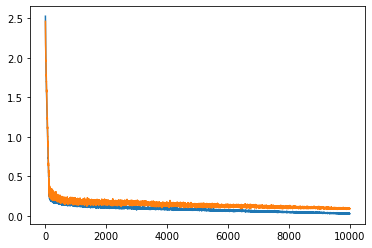

In [67]:
plt.plot(loss_list)
plt.plot(loss_list_test)

In [68]:
#evaluate model
model.eval()
with torch.no_grad():
    test_out = model(test_tensor.float())
    test_loss = criterion(test_out, test_label)
print (test_loss)
for i in range(0, 43):
    print (test_label[i], test_out[i])

tensor(0.0474)
tensor([2.1854]) tensor([2.2562])
tensor([2.5116]) tensor([2.5110])
tensor([2.3120]) tensor([2.3419])
tensor([2.3154]) tensor([2.3423])
tensor([2.4350]) tensor([2.4646])
tensor([2.3133]) tensor([2.3455])
tensor([2.0516]) tensor([2.1353])
tensor([2.6355]) tensor([2.6269])
tensor([2.3123]) tensor([2.3335])
tensor([2.3084]) tensor([2.3415])
tensor([2.0539]) tensor([2.1437])
tensor([2.0288]) tensor([2.1123])
tensor([2.0146]) tensor([2.0421])
tensor([2.0023]) tensor([2.0609])
tensor([2.6274]) tensor([2.6170])
tensor([2.3035]) tensor([2.3307])
tensor([1.8940]) tensor([1.9451])
tensor([2.2991]) tensor([2.3213])
tensor([1.8690]) tensor([1.9297])
tensor([2.2934]) tensor([2.3065])
tensor([1.8510]) tensor([1.9029])
tensor([2.2940]) tensor([2.3279])
tensor([2.2310]) tensor([2.2205])
tensor([1.8050]) tensor([1.8667])
tensor([1.7948]) tensor([1.8464])
tensor([2.2739]) tensor([2.3193])
tensor([1.7846]) tensor([1.8497])
tensor([1.7818]) tensor([1.8125])
tensor([2.2775]) tensor([2.3104])

In [69]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            },"/home/apk/NNMmodelstate_all")